In [70]:
import os
import glob
import cv2
import subprocess
import numpy as np 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Add current directory to path to allow imports

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

try:
    from scene.colmap_loader import read_extrinsics_binary, read_extrinsics_text, qvec2rotmat
except ImportError:
    print("Could not import scene.colmap_loader. Make sure you are running from the project root.")

# 3D Reconstruction Pipeline

input images --> feature extraction --> feature matching --> structure from motion --> Sparse Reconstruction

Reference: [Master the 3D Reconstruction Process: A Step-by-Step Guide](https://towardsdatascience.com/master-the-3d-reconstruction-process-step-by-step-guide/)

## Complete Pipeline Automation with COLMAP


In [88]:
def run_colmap_pipeline(image_folder, output_folder, colmap_path="colmap"):
    """
    Run the complete COLMAP pipeline from feature extraction to dense reconstruction.
    """

    # Create output directories if they don't exist
    sparse_folder = os.path.join(output_folder, "sparse")
    dense_folder = os.path.join(output_folder, "dense")
    stereo_folder = os.path.join(output_folder, "stereo")
    database_path = os.path.join(output_folder, "database.db")
    
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(sparse_folder, exist_ok=True)
    os.makedirs(dense_folder, exist_ok=True)
    os.makedirs(stereo_folder, exist_ok=True)
    
    # Step 1: Feature extraction
    print("Step 1: Feature extraction")
    feature_cmd = [
        colmap_path, "feature_extractor",
        "--database_path", database_path,
        "--image_path", image_folder,
        "--ImageReader.camera_model", "SIMPLE_PINHOLE",
        "--ImageReader.single_camera", "1",
        "--SiftExtraction.use_gpu", "1"
    ]
    
    try:
        subprocess.run(feature_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Feature extraction failed: {e}")
        return False
    
    # Step 2: Match features
    print("Step 2: Feature matching")
    match_cmd = [
        colmap_path, "exhaustive_matcher",
        "--database_path", database_path,
        "--SiftMatching.use_gpu", "1"
    ]
    
    try:
        subprocess.run(match_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Feature matching failed: {e}")
        return False
    
    # Step 3: Sparse reconstruction (Structure from Motion)
    print("Step 3: Sparse reconstruction")
    sfm_cmd = [
        colmap_path, "mapper",
        "--database_path", database_path,
        "--image_path", image_folder,
        "--output_path", sparse_folder
    ]
    
    try:
        subprocess.run(sfm_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Sparse reconstruction failed: {e}")
        return False
    
    # Find the largest sparse model
    sparse_models = glob.glob(os.path.join(sparse_folder, "*/"))
    if not sparse_models:
        print("No sparse models found")
        return False
    
    # Sort by model size (using number of images as proxy)
    largest_model = 0
    max_images = 0
    for i, model_dir in enumerate(sparse_models):
        images_txt = os.path.join(model_dir, "images.txt")
        if os.path.exists(images_txt):
            with open(images_txt, 'r') as f:
                num_images = sum(1 for line in f if line.strip() and not line.startswith("#"))
                num_images = num_images // 2  # Each image has 2 lines
                if num_images > max_images:
                    max_images = num_images
                    largest_model = i
    
    selected_model = os.path.join(sparse_folder, str(largest_model))
    print(f"Selected model {largest_model} with {max_images} images")
    
    # Step 4: Image undistortion
    print("Step 4: Image undistortion")
    undistort_cmd = [
        colmap_path, "image_undistorter",
        "--image_path", image_folder,
        "--input_path", selected_model,
        "--output_path", output_folder,
        "--output_type", "COLMAP"
    ]
    
    try:
        subprocess.run(undistort_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Image undistortion failed: {e}")
        return False
    
    # # Step 5: Dense reconstruction (Multi-View Stereo)
    # print("Step 5: Dense reconstruction")
    # mvs_cmd = [
    #     colmap_path, "patch_match_stereo",
    #     "--workspace_path", dense_folder,
    #     "--workspace_format", "COLMAP",
    #     "--PatchMatchStereo.geom_consistency", "true"
    # ]
    
    # try:
    #     subprocess.run(mvs_cmd, check=True)
    # except subprocess.CalledProcessError as e:
    #     print(f"Dense reconstruction failed: {e}")
    #     return False
    
    # # Step 6: Stereo fusion
    # print("Step 6: Stereo fusion")
    # fusion_cmd = [
    #     colmap_path, "stereo_fusion",
    #     "--workspace_path", dense_folder,
    #     "--workspace_format", "COLMAP",
    #     "--input_type", "geometric",
    #     "--output_path", os.path.join(dense_folder, "fused.ply")
    # ]
    
    # try:
    #     subprocess.run(fusion_cmd, check=True)
    # except subprocess.CalledProcessError as e:
    #     print(f"Stereo fusion failed: {e}")
    #     return False
    
    print("Pipeline completed successfully!")
    return True

In [90]:
# image and output folder paths
image_folder = "data/silverlakeCustom/input/"
output_folder = "data/silverlakeCustom"
    
# Path to COLMAP executable - using full path for Windows
colmap_path = r"C:\Program Files\COLMAP-3.8-windows-cuda\COLMAP.bat"
    
run_colmap_pipeline(image_folder, output_folder, colmap_path)

Step 1: Feature extraction
Step 2: Feature matching
Step 2: Feature matching
Step 3: Sparse reconstruction
Step 3: Sparse reconstruction
Selected model 0 with 0 images
Step 4: Image undistortion
Selected model 0 with 0 images
Step 4: Image undistortion
Pipeline completed successfully!
Pipeline completed successfully!


True

## Pairwise Image Feature Matching 

### Feature Extraction

In [30]:
def extract_features(image_path, feature_method="sift", max_features=1000): 
    """
    Extract features from an image using different methods
    """

    # read image in color and convert to grayscale
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # initialize feature detector
    if feature_method.lower() == "sift":
        detector = cv2.SIFT_create(nfeatures=max_features)
    elif feature_method.lower() == "surf":
        # Note: SURF is patented and may not be available in all OpenCV distributions
        detector = cv2.xfeatures2d.SURF_create(400)  # Adjust thresho
    elif feature_method.lower() == "orb":
        detector = cv2.ORB_create(nfeatures=max_features)
    else:
        raise ValueError(f"Unsupported feature method: {feature_method}")
    
    # detect and compute keypoints and desccriptors
    keypoints, descriptors = detector.detectAndCompute(gray, None)

    # Create visualization
    img_with_features = cv2.drawKeypoints(
        img, keypoints, None, 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    return keypoints, descriptors, img_with_features

In [31]:
image_path = "data/silverlakeCustom/input/0035.jpg" 

# Extract features with different methods
kp_sift, desc_sift, vis_sift = extract_features(image_path, 'sift')
kp_orb, desc_orb, vis_orb = extract_features(image_path, 'orb')

print(f"Extracted {len(kp_sift)} SIFT features")
print(f"Extracted {len(kp_orb)} ORB features")

Extracted 1000 SIFT features
Extracted 1000 ORB features


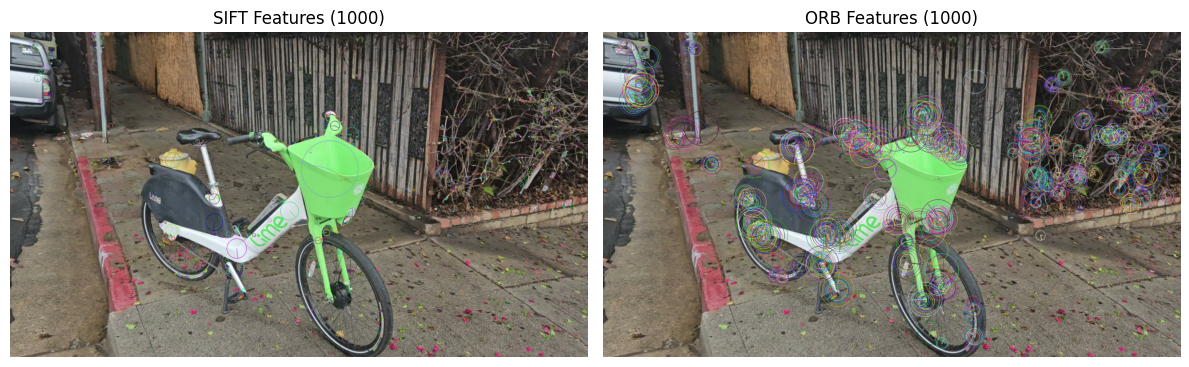

In [32]:
# plot results
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.title(f'SIFT Features ({len(kp_sift)})')
plt.imshow(cv2.cvtColor(vis_sift, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.title(f'ORB Features ({len(kp_orb)})')
plt.imshow(cv2.cvtColor(vis_orb, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
plt.tight_layout()
plt.show()

### Feature matching and correspondence

In [33]:
def match_features(descriptors1, descriptors2, method='flann', ratio_thresh=0.75):
    """
    Match features between 2 images using different methods
    """

    # convert descriptors to appropriate type
    if descriptors1 is None or descriptors2 is None: 
        return []
    
    if method.lower() == 'flann':
        # FLANN parameters
        if descriptors1.dtype != np.float32: 
            descriptors1 = np.float32(descriptors1)
        if descriptors2.dtype != np.float32: 
            descriptors2 = np.float32(descriptors2)
        
        FLANN_INDEX_KDTREEE =1
        index_params = dict(algorithm=FLANN_INDEX_KDTREEE, trees=5)
        search_params = dict(checks=50) # higher values == more accurate

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    else:  # Brute Force
        # For ORB descriptors
        if descriptors1.dtype == np.uint8:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        else:  # For SIFT and SURF descriptors
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for match in matches:
        if len(match) == 2:  # Sometimes fewer than 2 matches are returned
            m, n = match
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    
    return good_matches

def visualize_matches(img1, kp1, img2, kp2, matches, max_display=100):
    """
    Create a visualization of feature matches between two images.
    """

    # Limit the number of matches to display
    matches_to_draw = matches[:min(max_display, len(matches))]
    
    # Create match visualization
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, matches_to_draw, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    return match_img

Found 3135 good matches


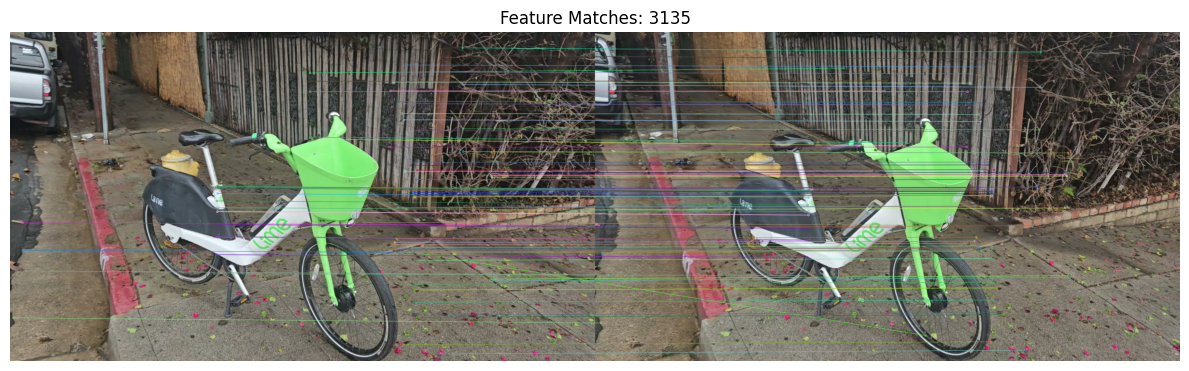

In [34]:
# Load two images
img1_path = "data/silverlakeCustom/input/0035.jpg"  # Replace with your image paths
img2_path = "data/silverlakeCustom/input/0036.jpg"

# Extract features using SIFT (or your preferred method)
kp1, desc1, _ = extract_features(img1_path, 'sift', 10000)
kp2, desc2, _ = extract_features(img2_path, 'sift', 10000)

# Match features
good_matches = match_features(desc1, desc2, method='flann')

print(f"Found {len(good_matches)} good matches")

# Visualize matches
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
match_visualization = visualize_matches(img1, kp1, img2, kp2, good_matches)
    
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(match_visualization, cv2.COLOR_BGR2RGB))
plt.title(f"Feature Matches: {len(good_matches)}")
plt.axis('off')
plt.tight_layout()
plt.show()

### Structure from Motion

In [37]:
def estimate_pose(kp1, kp2, matches, K, method=cv2.RANSAC, prob=0.999, threshold=1.0):
    """
    Estimate relative pose between 2 cameras using matched feature
    """

    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Estimate essential matrix
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method, prob, threshold)

    # Recover pose from essential matrix
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K, mask=mask)

    inlier_matches = [matches[i] for i in range(len(matches)) if mask[i] > 0]
    
    return R, t, mask, inlier_matches

def triangulate_points(kp1,kp2, matches, K, R1, t1, R2, t2):
    """
    Triangulate 3D pooints from 2 views. 
    """

    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Create projection matrices
    P1 = np.dot(K, np.hstack((R1, t1)))
    P2 = np.dot(K, np.hstack((R2, t2)))

    # Triangulate points
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

    # Convert to 3D points
    points_3d = points_4d[:3] / points_4d[3]

    return points_3d.T

def visualize_points_and_cameras(points_3d, R1, t1, R2, t2): 
    """
    Visualize 3D points and camera positions.
    """

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='b', s=1)

    # Helper function to create camera visualization
    def plot_camera(R, t, color):
        # Camera center
        center = -R.T @ t
        ax.scatter(center[0], center[1], center[2], c=color, s=100, marker='o')
        
        # Camera axes (showing orientation)
        axes_length = 0.5  # Scale to make it visible
        for i, c in zip(range(3), ['r', 'g', 'b']):
            axis = R.T[:, i] * axes_length
            ax.quiver(center[0], center[1], center[2], 
                      axis[0], axis[1], axis[2], 
                      color=c, arrow_length_ratio=0.1)

    # Plot cameras
    plot_camera(R1, t1, 'red')
    plot_camera(R2, t2, 'green')
    
    ax.set_title('3D Reconstruction: Points and Cameras')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Try to make axes equal
    max_range = np.max([
        np.max(points_3d[:, 0]) - np.min(points_3d[:, 0]),
        np.max(points_3d[:, 1]) - np.min(points_3d[:, 1]),
        np.max(points_3d[:, 2]) - np.min(points_3d[:, 2])
    ])

    mid_x = (np.max(points_3d[:, 0]) + np.min(points_3d[:, 0])) * 0.5
    mid_y = (np.max(points_3d[:, 1]) + np.min(points_3d[:, 1])) * 0.5
    mid_z = (np.max(points_3d[:, 2]) + np.min(points_3d[:, 2])) * 0.5
    
    # ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
    # ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
    # ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)
    
    plt.tight_layout()
    plt.show()

Estimated pose with 2768 inliers out of 3120 matches


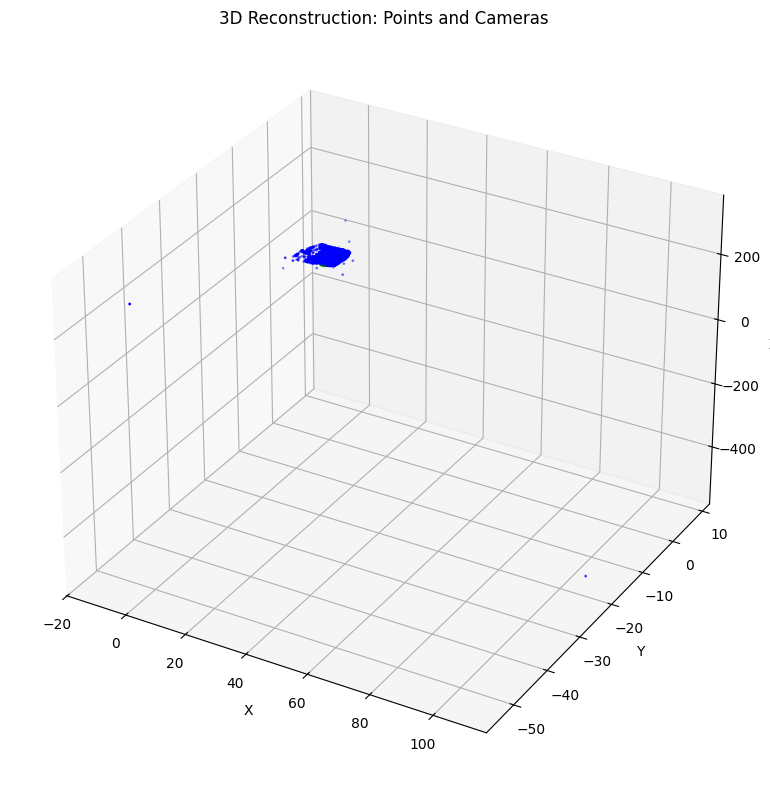

In [38]:
# Load two images
img1_path = "data/silverlakeCustom/input/0035.jpg"  # Replace with your image paths
img2_path = "data/silverlakeCustom/input/0036.jpg"

# Extract features using SIFT (or your preferred method)
kp1, desc1, _ = extract_features(img1_path, 'sift', 10000)
kp2, desc2, _ = extract_features(img2_path, 'sift', 10000)

K = np.array([
    [ 2304.0, 0.0, 960.0],
    [ 0.0, 2304.0, 540.0],
    [ 0.0, 0.0, 1.0]
])

good_matches = match_features(desc1, desc2, method='flann')

# For first camera, we use identity rotation and zero translation
R1 = np.eye(3)
t1 = np.zeros((3, 1))

R2, t2, mask, inliers = estimate_pose(kp1, kp2, good_matches, K)
print(f"Estimated pose with {np.sum(mask)} inliers out of {len(good_matches)} matches")

points_3d = triangulate_points(kp1,kp2, good_matches, K, R1, t1, R2, t2)
visualize_points_and_cameras(points_3d, R1, t1, R2, t2)

## Incremental Structure from Motion (SfM)

To reconstruct a 3D scene from a sequence of images (video), we need to go beyond pairwise reconstruction. We use an **Incremental SfM** approach:

1.  **Initialize**: Start with the first pair of images.
2.  **Register**: For each subsequent image, match features with the previous one.
3.  **Pose Estimation**: Estimate the relative pose ($R, t$) between the current and previous frame.
4.  **Accumulate Pose**: Chain the transformations to get the camera pose in the global coordinate system.
    *   $C_{i+1} = T_{i \to i+1} \times C_{i}$
5.  **Triangulate**: Compute 3D points for the new matches and transform them to the global frame.

### Camera Calibration

In [35]:
def calibrate_from_images(img_path: str, 
                          feature_method: str = "sift", max_features : int = 1000, 
                          ratio_thres: float = 0.75, min_matches: int = 8)-> tuple:
    """
    self-calibration from images without using checkerboard.
    Uses feature matching and fundamental matrix estimation.
    
    :param images: Description
    :type images: list(str)
    :param feature_method: Description
    :type feature_method: str
    :param max_features: Description
    :type max_features: int
    :param ratio_thres: Description
    :type ratio_thres: float
    :param min_matches: Description
    :type min_matches: int
    :return: Description
    :rtype: Any
    """

    images = []
    for root, _, files in os.walk(img_path):
        for file in files:
            full_path = os.path.join(root, file)
            images.append(full_path)

    # initialize feature detector
    if feature_method == "sift":
        detector = cv2.SIFT_create(nfeatures=max_features)
    elif feature_method == 'orb':
        detector = cv2.ORB_create(nfeatures=max_features)
    else:
        raise ValueError(f"Unknown feature detector: {feature_method}")
    
    # read first image to get size
    img0 = cv2.imread(str(images[0]))
    if img0 is None:
        raise ValueError(f"Could not read image at {image_path[0]}")
    h, w = img0.shape[:2]

    # initial guess for intrinsic matrix
    focal_length = max(h,w) * 1.2
    cx, cy = w / 2, h / 2

    K = np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1],
    ], dtype=np.float64)

    print("Extracting features...")
    keypoints = []
    descriptors = []

    for img_path in tqdm(images, desc="feature extraction"):
        kp, desc, _ = extract_features(img_path, feature_method, max_features)
        keypoints.append(kp)
        descriptors.append(desc)

    print("Matching features...")
    focal_lengths = []

    num_pairs = len(images) - 1

    for i in range(num_pairs):
        desc1 = descriptors[i]
        desc2 = descriptors[i+1]
        if desc1 is None or desc2 is None: 
            print(f"WARNING: Missing descriptors for pair ({i}, {i+1}). Skipping pair")
            continue
    
        good_matches = match_features(desc1, desc2)

        if len(good_matches) < min_matches:
            print(f"WARNING: Only {len(good_matches)} good matches found for pair ({i}, {i+1}). Expecting {min_matches} Skipping pair")
            continue

        # Get matching points
        pts1 = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches])
        pts2 = np.float32([keypoints[i+1][m.trainIdx].pt for m in good_matches])

        # Estimate fundamental matrix
        F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 3.0)

        if F is None:
            print(f"WARNING: Unable to find Fundamental Matrix from point matches.")
            continue

        # estimate focal length from fundamental matrix
        # for calibrated cameras: E = K^T * F * K
        # estimate focal_length from F
        pts1_inliers = pts1[mask.ravel() == 1]
        pts2_inliers = pts2[mask.ravel() == 1]

        if len(pts1_inliers) > 20:
            # use median focal length estimation
            focal_est = estimate_focal_from_fundamental(F, pts1_inliers, pts2_inliers, w, h)
            if focal_est > 0 and focal_est < max(w, h) * 2: 
                focal_lengths.append(focal_est)

    K = np.identity(3)
    # refine focal length estimate
    if len(focal_lengths) > 0: 
        focal_length = np.median(focal_lengths)
        print(f"Estimated focal length: {focal_length:0.2f} from {len(focal_lengths)} pairs.")

        K = np.array([
            [focal_length, 0, cx],
            [0, focal_length, cy],
            [0, 0, 1],
        ])
    else: 
        print(f"WARNING: Could not estimate focal length, using initial guess {len(focal_lengths)}.")

    # assume no distortion for now
    dist_coeffs = np.zeros(5)

    return K, dist_coeffs

def estimate_focal_from_fundamental(F: np.ndarray, pts1: np.ndarray,
                                    pts2: np.ndarray, w: int, h: int) -> float:
    """
    Estimate focal length from fundamental matrix
    
    :param F: Description
    :type F: np.ndarray
    :param pts1: Description
    :type pts1: np.ndarray
    :param pts2: Description
    :type pts2: np.ndarray
    :param w: Description
    :type w: int
    :param h: Description
    :type h: int
    :return: Description
    :rtype: float
    """

    # normalize points
    pts1_norm = pts1 - np.array([w/2, h/2])
    pts2_norm = pts2 - np.array([w/2, h/2])

    # Estimate focal length using property that F ~ [t]_x * R 
    # for calibrated cameras
    scale = np.median(np.linalg.norm(pts1_norm, axis=1))

    if scale > 0: 
        focal = max(w, h) / (2 * np.tan(np.arctan(scale / max(w,h)) / 2))
        return focal
    
    #default guess
    print(f"WARNING: return default camera intrinsic values.")
    return max(w, h) * 1.2


In [36]:
# img_path = "data/silverlakeOpenCV/input"
# K, dist_coeffs = calibrate_from_images(img_path)

# print(f"{K}")



Extracting features...


feature extraction:   0%|          | 0/70 [00:00<?, ?it/s]

Matching features...
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Reconstuction

In [ ]:
def reconstruct_sequence(image_folder, K):
    images = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))
    if len(images) < 2:
        print("Not enough images")
        return [], [], [], [], [], [], []

    # Global camera poses (World to Camera)
    # We store [R|t] matrices
    poses = [np.eye(4)] 
    
    # All 3D points
    all_points_3d = []
    all_colors = []
    all_tracks = [] # Track info for each 3D point: list of (image_idx, keypoint_idx)
    
    # Store keypoints and descriptors for each image
    # keypoints_data[image_index] = (keypoints, descriptors)
    keypoints_data = {}
    
    # Store matches between pairs
    # matches_data[(idx1, idx2)] = matches
    matches_data = {}
    
    # Keep track of which images are actually part of the reconstruction
    valid_images = set()

    # Process consecutive pairs
    for i in tqdm(range(len(images) - 1), desc="Processing sequence"):
        img1_path = images[i]
        img2_path = images[i+1]
        
        # 1. Feature Extraction
        # Check if we already extracted features for img1
        if i in keypoints_data:
            kp1, desc1 = keypoints_data[i]
        else:
            kp1, desc1, _ = extract_features(img1_path, 'sift', 2000)
            keypoints_data[i] = (kp1, desc1)
            
        # Always extract for img2 (will be reused in next iteration)
        kp2, desc2, _ = extract_features(img2_path, 'sift', 2000)
        keypoints_data[i+1] = (kp2, desc2)
        
        # 2. Matching
        matches = match_features(desc1, desc2, method='flann')
        
        # Store matches
        matches_data[(i, i+1)] = matches
        
        # At least 8 matching point pairs required for 8-point algorithm
        if len(matches) < 8:
            print(f"Not enough matches between {i} and {i+1}")
            poses.append(poses[-1]) # Assume no motion if fails
            continue
            
        # 3. Pose Estimation
        # Estimate motion from i to i+1
        # Note: estimate_pose returns inlier_matches which we should use
        R_rel, t_rel, mask, inlier_matches = estimate_pose(kp1, kp2, matches, K)
        
        # Check if pose estimation was successful enough
        GEO_VERIF_THRESH = 8
        if len(inlier_matches) < GEO_VERIF_THRESH:
            print(f"Pose estimation failed or too few inliers ({len(inlier_matches)}) for pair {i}-{i+1}")
            poses.append(poses[-1]) # Assume no motion
            continue

        # Create 4x4 transformation matrix for relative motion (i -> i+1)
        T_rel = np.eye(4)
        T_rel[:3, :3] = R_rel
        T_rel[:3, 3] = t_rel.flatten()
        
        # 4. Accumulate Pose
        # recoverPose gives transform from Cam 1 to Cam 2 (x2 = R x1 + t)
        # This is T_{i->i+1}.
        # We want World-to-Camera pose C.
        # C_{i+1} = T_{i->i+1} * C_i
        
        current_pose = poses[-1]
        new_pose = T_rel @ current_pose
        poses.append(new_pose)
        
        # 5. Triangulate
        # We triangulate in the frame of Camera i
        P1 = K @ np.eye(3, 4)
        P2 = K @ np.hstack((R_rel, t_rel))
        
        pts1 = np.float32([kp1[m.queryIdx].pt for m in inlier_matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in inlier_matches])
        
        points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        points_3d_local = (points_4d[:3] / points_4d[3]).T
        
        # Transform points to World Frame
        # X_local = C_i * X_world  => X_world = C_i^{-1} * X_local
        C_inv = np.linalg.inv(current_pose)
        
        points_3d_local_h = np.hstack((points_3d_local, np.ones((len(points_3d_local), 1))))
        points_3d_world = (C_inv @ points_3d_local_h.T).T
        points_3d_world = points_3d_world[:, :3]
        
        # Filter points (remove those behind camera or too far)
        NEAR_CLIP = 0.1
        FAR_CLIP = 100
        valid_mask = (points_3d_local[:, 2] > NEAR_CLIP) & (points_3d_local[:, 2] < FAR_CLIP)
        
        if np.sum(valid_mask) > 0:
            all_points_3d.append(points_3d_world[valid_mask])
            
            # Get colors
            img1 = cv2.imread(img1_path)
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            colors = []
            for pt in pts1[valid_mask]:
                x, y = int(pt[0]), int(pt[1])
                if 0 <= y < img1.shape[0] and 0 <= x < img1.shape[1]:
                    colors.append(img1[y, x] / 255.0)
                else:
                    colors.append([0, 0, 0])
            all_colors.append(np.array(colors))
            
            # Store tracks for these points
            # We need to know which keypoints generated these points
            valid_matches = [inlier_matches[k] for k in range(len(inlier_matches)) if valid_mask[k]]
            for m in valid_matches:
                # Track: list of (image_idx, keypoint_idx)
                # We have a track of length 2 for this pair
                all_tracks.append([(i, m.queryIdx), (i+1, m.trainIdx)])
            
            # Mark these images as valid since they contributed to the map
            valid_images.add(i)
            valid_images.add(i+1)

    if len(all_points_3d) > 0:
        return np.vstack(all_points_3d), np.vstack(all_colors), poses, keypoints_data, matches_data, all_tracks, valid_images
    else:
        return np.array([]), np.array([]), poses, keypoints_data, matches_data, [], set()

Starting reconstruction for data/silverlake/input/


Processing sequence:   0%|          | 0/69 [00:00<?, ?it/s]

Pose estimation failed or too few inliers (0) for pair 0-1
Pose estimation failed or too few inliers (5) for pair 1-2
Pose estimation failed or too few inliers (5) for pair 1-2
Pose estimation failed or too few inliers (0) for pair 30-31
Pose estimation failed or too few inliers (0) for pair 30-31
Reconstructed 29566 points from 70 cameras
Valid images: 68 out of 70
Reconstructed 29566 points from 70 cameras
Valid images: 68 out of 70


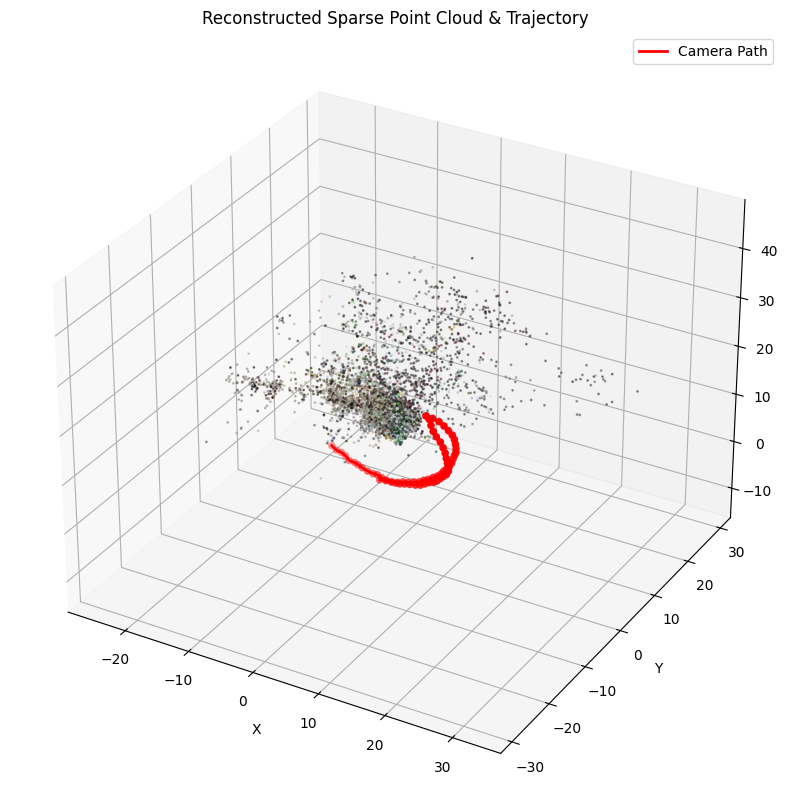

In [118]:
# Run reconstruction on the sequence
image_folder = "data/silverlake/input/"
print(f"Starting reconstruction for {image_folder}")

# K matrix for camera intrinsics
K = np.array([
    [ 2254.8, 0.0, 939.5],
    [ 0.0, 2254.8, 529],
    [ 0.0, 0.0, 1.0]
])

points, colors, poses, keypoints_data, matches_data, tracks, valid_images = reconstruct_sequence(image_folder, K)

print(f"Reconstructed {len(points)} points from {len(poses)} cameras")
print(f"Valid images: {len(valid_images)} out of {len(poses)}")

# Visualize Result
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Downsample points for faster plotting
step = 5
if len(points) > 0:
    ax.scatter(points[::step, 0], points[::step, 1], points[::step, 2], 
               c=colors[::step], s=1, alpha=0.5)

# Plot camera trajectory
cam_centers = []
for i, pose in enumerate(poses):
    # Only plot valid cameras
    if i in valid_images:
        # Pose is World-to-Camera. We want Camera center in World.
        # C = -R^T * t
        R = pose[:3, :3]
        t = pose[:3, 3]
        center = -R.T @ t
        cam_centers.append(center)

if len(cam_centers) > 0:
    cam_centers = np.array(cam_centers)
    ax.plot(cam_centers[:, 0], cam_centers[:, 1], cam_centers[:, 2], 'r-', linewidth=2, label='Camera Path')
    ax.scatter(cam_centers[:, 0], cam_centers[:, 1], cam_centers[:, 2], c='r', s=20)

ax.set_title('Reconstructed Sparse Point Cloud & Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Auto-scale axes
if len(points) > 0 and len(cam_centers) > 0:
    all_coords = np.vstack((points[::step], cam_centers))
    max_range = np.array([all_coords[:,0].max()-all_coords[:,0].min(), 
                          all_coords[:,1].max()-all_coords[:,1].min(), 
                          all_coords[:,2].max()-all_coords[:,2].min()]).max() / 2.0

    mid_x = (all_coords[:,0].max()+all_coords[:,0].min()) * 0.5
    mid_y = (all_coords[:,1].max()+all_coords[:,1].min()) * 0.5
    mid_z = (all_coords[:,2].max()+all_coords[:,2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

## Result Comparison

Reference: [kabsch_umeyama alignment algorithm](https://zpl.fi/aligning-point-patterns-with-kabsch-umeyama-algorithm/)

In [119]:
def get_colmap_trajectory(model_path):
    """Load camera centers from COLMAP model"""
    # Try binary first, then text
    bin_path = os.path.join(model_path, "images.bin")
    txt_path = os.path.join(model_path, "images.txt")
    
    if os.path.exists(bin_path):
        images = read_extrinsics_binary(bin_path)
    elif os.path.exists(txt_path):
        images = read_extrinsics_text(txt_path)
    else:
        print(f"No COLMAP model found at {model_path}")
        return {}
        
    trajectory = {}
    for img_id, img in images.items():
        R = qvec2rotmat(img.qvec)
        t = img.tvec
        # Camera center C = -R^T * t
        center = -R.T @ t
        trajectory[img.name] = center
        
    return trajectory

def align_trajectories(traj_est, traj_ref):
    """
    Align estimated trajectory to reference using svd mesh alignment method (scale, rotation, translation).
    """
    # Extract matching points
    common_names = sorted(list(set(traj_est.keys()) & set(traj_ref.keys())))
    if len(common_names) < 3:
        print("Not enough common points to align")
        return None, None, None
        
    P = np.array([traj_est[name] for name in common_names])
    Q = np.array([traj_ref[name] for name in common_names])
    
    # Centroids
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)
    
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q
    
    # Scale
    scale_P = np.sqrt(np.sum(P_centered**2) / len(P))
    scale_Q = np.sqrt(np.sum(Q_centered**2) / len(Q))
    
    if scale_P < 1e-6:
        s = 1.0
    else:
        s = scale_Q / scale_P
    
    P_scaled = P_centered * s
    
    # rigid alignment In NumPy (from slides)
    H = P_scaled.T @ Q_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    
    # Handle reflection
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T
        
    # Transform P
    P_aligned = (P - centroid_P) * s @ R.T + centroid_Q
    
    return P_aligned, Q, common_names


Loading COLMAP model from data/silverlakeCustom\sparse\0


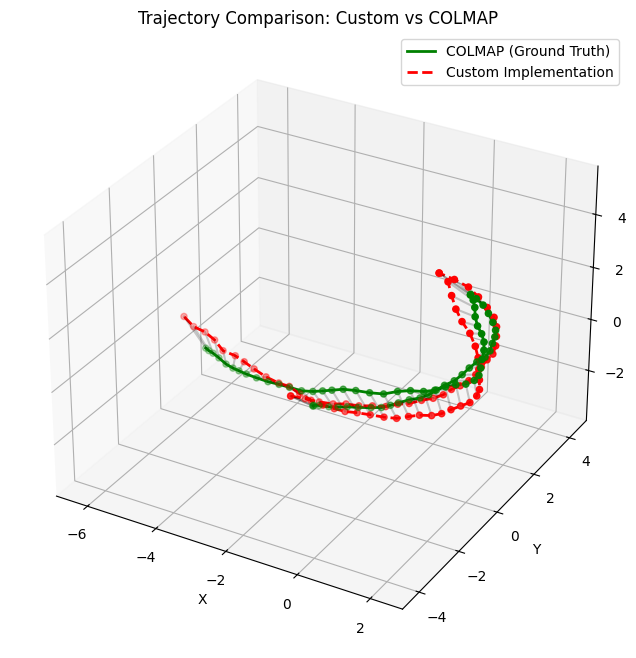

Mean Position Error: 0.5223
Max Position Error: 1.1494


In [120]:
# 1. Get custom trajectory dict from previous execution
custom_trajectory = {}
image_files = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

for i in range(min(len(poses), len(image_files))):
    filename = os.path.basename(image_files[i])
    pose = poses[i]
    R = pose[:3, :3]
    t = pose[:3, 3]
    center = -R.T @ t
    custom_trajectory[filename] = center

# 2. Get COLMAP trajectory
# COLMAP sparse model output it should be in data/silverlakeCustom/sparse/0
sparse_root = os.path.join(output_folder, "sparse")
colmap_trajectory = {}

if os.path.exists(sparse_root):
    subdirs = [d for d in os.listdir(sparse_root) if os.path.isdir(os.path.join(sparse_root, d))]
    if subdirs:
        # Use the first model found (usually '0')
        model_path = os.path.join(sparse_root, subdirs[0])
        print(f"Loading COLMAP model from {model_path}")
        colmap_trajectory = get_colmap_trajectory(model_path)
    else:
        print(f"No sparse model subdirectories found in {sparse_root}.")
else:
    print(f"Sparse directory not found: {sparse_root}")

# 3. Align and Plot
if colmap_trajectory and custom_trajectory:
    aligned_custom, aligned_colmap, names = align_trajectories(custom_trajectory, colmap_trajectory)
    
    if aligned_custom is not None:
        # Plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        ax.plot(aligned_colmap[:, 0], aligned_colmap[:, 1], aligned_colmap[:, 2], 'g-', label='COLMAP (Ground Truth)', linewidth=2)
        ax.scatter(aligned_colmap[:, 0], aligned_colmap[:, 1], aligned_colmap[:, 2], c='g', s=20)
        
        ax.plot(aligned_custom[:, 0], aligned_custom[:, 1], aligned_custom[:, 2], 'r--', label='Custom Implementation', linewidth=2)
        ax.scatter(aligned_custom[:, 0], aligned_custom[:, 1], aligned_custom[:, 2], c='r', s=20)
        
        # Draw lines connecting corresponding points
        for i in range(len(aligned_custom)):
            ax.plot([aligned_custom[i, 0], aligned_colmap[i, 0]],
                    [aligned_custom[i, 1], aligned_colmap[i, 1]],
                    [aligned_custom[i, 2], aligned_colmap[i, 2]], 'k-', alpha=0.2)
            
        ax.set_title('Trajectory Comparison: Custom vs COLMAP')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        
        # Set equal aspect ratio
        all_pts = np.vstack((aligned_colmap, aligned_custom))
        max_range = np.array([all_pts[:,0].max()-all_pts[:,0].min(), 
                              all_pts[:,1].max()-all_pts[:,1].min(), 
                              all_pts[:,2].max()-all_pts[:,2].min()]).max() / 2.0
        mid_x = (all_pts[:,0].max()+all_pts[:,0].min()) * 0.5
        mid_y = (all_pts[:,1].max()+all_pts[:,1].min()) * 0.5
        mid_z = (all_pts[:,2].max()+all_pts[:,2].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)
        
        plt.show()
        
        # Compute error
        errors = np.linalg.norm(aligned_custom - aligned_colmap, axis=1)
        print(f"Mean Position Error: {np.mean(errors):.4f}")
        print(f"Max Position Error: {np.max(errors):.4f}")
    else:
        print("Alignment failed.")
else:
    print("Could not compare trajectories. Ensure both custom reconstruction and COLMAP pipeline have run.")

## Quality Assessment

We can assess the quality of the reconstruction using:
1. **Reprojection Error**: The distance between the projected 3D points and their observed 2D keypoints.
2. **Visual Inspection**: Exporting the point cloud to a standard format (PLY) for viewing in external tools like MeshLab.
3. **Reprojection Visualization**: Visualizing the alignment of projected points on the original images.

In [126]:
def calculate_reprojection_error(points_3d, poses, K, tracks, keypoints_data, valid_images):
    """
    Calculate the mean reprojection error for the reconstruction.
    """
    total_error = 0.0
    total_points = 0
    
    errors = []
    
    print(f"Calculating error for {len(points_3d)} points...")
    
    for pt_idx, point_3d in enumerate(points_3d):
        track = tracks[pt_idx]
        
        # Homogeneous 3D point
        pt3d_h = np.append(point_3d, 1.0)
        
        for img_idx, kp_idx in track:
            if img_idx not in valid_images:
                continue
                
            # Get camera pose
            pose = poses[img_idx] # World to Camera
            
            # Project point
            # P_cam = R * P_world + t  => P_cam = Pose * P_world_h
            pt_cam = pose @ pt3d_h
            
            # Check if point is in front of camera
            if pt_cam[2] <= 0:
                continue
                
            # Project to image plane
            # p_img = K * P_cam
            pt_img_h = K @ pt_cam[:3]
            pt_img = pt_img_h[:2] / pt_img_h[2]
            
            # Get observed point
            kp = keypoints_data[img_idx][0][kp_idx]
            obs_pt = np.array(kp.pt)
            
            # Calculate error
            error = np.linalg.norm(pt_img - obs_pt)
            total_error += error
            total_points += 1
            errors.append(error)
            
    mean_error = total_error / total_points if total_points > 0 else 0
    return mean_error, np.array(errors)

def visualize_reprojection(image_folder, points_3d, poses, K, tracks, keypoints_data, valid_images, image_idx_to_show=0):
    """
    Visualize reprojection on a specific image.
    """
    images = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))
    if image_idx_to_show >= len(images) or image_idx_to_show not in valid_images:
        print(f"Image {image_idx_to_show} is not valid or out of range.")
        return
        
    img_path = images[image_idx_to_show]
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    
    # Collect points visible in this image
    reprojected_points = []
    observed_points = []
    
    pose = poses[image_idx_to_show]
    
    for pt_idx, track in enumerate(tracks):
        # Check if this point is observed in this image
        kp_idx = -1
        for t_img_idx, t_kp_idx in track:
            if t_img_idx == image_idx_to_show:
                kp_idx = t_kp_idx
                break
        
        if kp_idx != -1:
            # Project point
            pt3d_h = np.append(points_3d[pt_idx], 1.0)
            pt_cam = pose @ pt3d_h
            
            if pt_cam[2] > 0:
                pt_img_h = K @ pt_cam[:3]
                pt_img = pt_img_h[:2] / pt_img_h[2]
                
                reprojected_points.append(pt_img)
                
                # Get observed
                kp = keypoints_data[image_idx_to_show][0][kp_idx]
                observed_points.append(kp.pt)
                
    reprojected_points = np.array(reprojected_points)
    observed_points = np.array(observed_points)
    
    if len(reprojected_points) > 0:
        plt.scatter(observed_points[:, 0], observed_points[:, 1], c='g', marker='+', s=30, label='Observed')
        plt.scatter(reprojected_points[:, 0], reprojected_points[:, 1], c='r', marker='x', s=30, label='Reprojected')
        
        # Draw lines
        for i in range(len(reprojected_points)):
            plt.plot([observed_points[i, 0], reprojected_points[i, 0]],
                     [observed_points[i, 1], reprojected_points[i, 1]], 'y-', alpha=0.3)
                     
        plt.legend()
        plt.title(f"Reprojection for Image {image_idx_to_show}")
    else:
        print("No points observed in this image.")
        
    plt.axis('off')
    plt.show()

def export_to_ply(points, colors, output_path):
    """
    Export point cloud to PLY format.
    """
    with open(output_path, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        
        for i in range(len(points)):
            pt = points[i]
            col = (colors[i] * 255).astype(int)
            f.write(f"{pt[0]} {pt[1]} {pt[2]} {col[0]} {col[1]} {col[2]}\n")
            
    print(f"Exported PLY to {output_path}")

Calculating error for 29566 points...
Mean Reprojection Error: 0.2362 pixels
Median Reprojection Error: 0.1976 pixels
Mean Reprojection Error: 0.2362 pixels
Median Reprojection Error: 0.1976 pixels


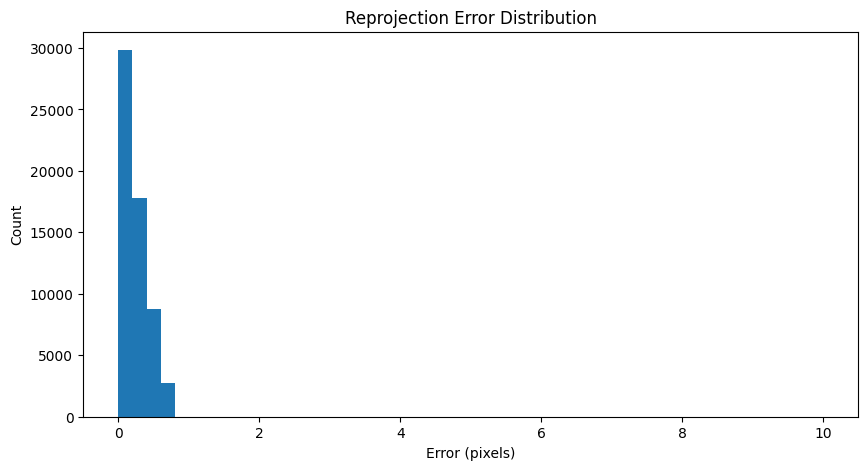

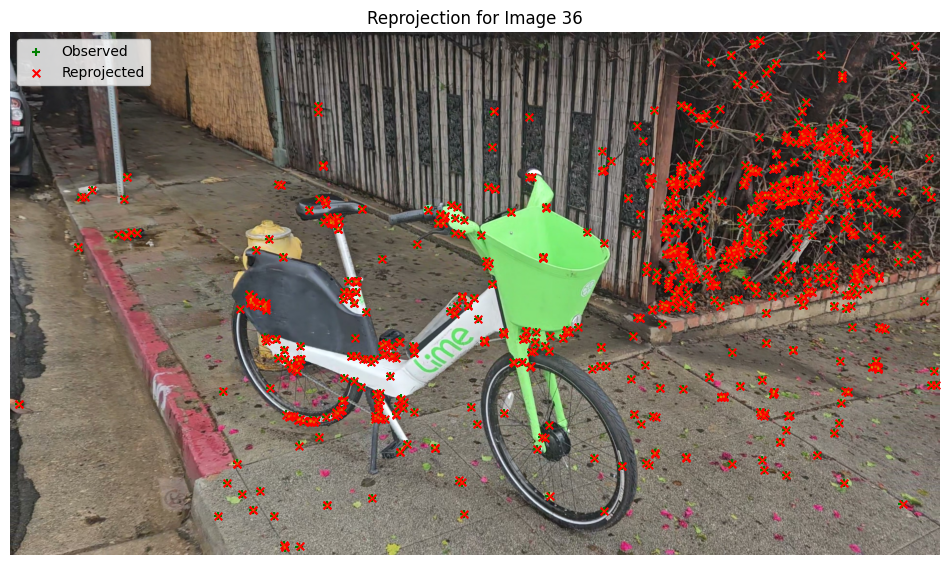

Exported PLY to data\silverlakeOpenCV\reconstruction.ply


In [ ]:
# Calculate Reprojection Error
if len(points) > 0:
    mean_error, all_errors = calculate_reprojection_error(points, poses, K, tracks, keypoints_data, valid_images)
    print(f"Mean Reprojection Error: {mean_error:.4f} pixels")
    print(f"Median Reprojection Error: {np.median(all_errors):.4f} pixels")
    
    plt.figure(figsize=(10, 5))
    plt.hist(all_errors, bins=50, range=(0, 10))
    plt.title("Reprojection Error Distribution")
    plt.xlabel("Error (pixels)")
    plt.ylabel("Count")
    plt.show()
    
    # Visualize Reprojection for a valid image
    valid_list = list(valid_images)
    SAMPLE_IMG = len(valid_list)//2
    if len(valid_list) > 0:
        # Pick a middle image
        idx_to_show = valid_list[SAMPLE_IMG]
        visualize_reprojection(image_folder, points, poses, K, tracks, keypoints_data, valid_images, idx_to_show)
        
    # Export to PLY
    ply_output = os.path.join("data", "silverlakeOpenCV", "reconstruction.ply")
    export_to_ply(points, colors, ply_output)
else:
    print("No points to analyze.")

## Exporting Custom Calibration to COLMAP for training

In [124]:
import sqlite3
from scene.colmap_loader import rotmat2qvec

def write_colmap_text(output_path, cameras, images, points3D, keypoints_data, tracks, valid_images):
    """
    Write COLMAP data to text files.
    """
    os.makedirs(output_path, exist_ok=True)
    
    # Build a map from (image_id, point2d_idx) -> point3d_id
    # tracks is a list of lists of (image_idx, kp_idx)
    # point3d_id is 1-based index corresponding to tracks list
    point2d_to_3d = {}
    for pt_idx, track in enumerate(tracks):
        pt3d_id = pt_idx + 1
        for img_idx, kp_idx in track:
            # Convert 0-based image index to 1-based image_id
            img_id = img_idx + 1
            point2d_to_3d[(img_id, kp_idx)] = pt3d_id
    
    # 1. Write cameras.txt
    with open(os.path.join(output_path, "cameras.txt"), "w") as f:
        f.write("# Camera list with one line of data per camera.\n")
        f.write("#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]\n")
        for cam_id, cam in cameras.items():
            f.write(f"{cam_id} {cam['model']} {cam['width']} {cam['height']} " + 
                    " ".join(map(str, cam['params'])) + "\n")
            
    # 2. Write images.txt
    with open(os.path.join(output_path, "images.txt"), "w") as f:
        f.write("# Image list with two lines of data per image.\n")
        f.write("#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME\n")
        f.write("#   POINTS2D[] as (X, Y, POINT3D_ID)\n")
        
        sorted_img_ids = sorted(images.keys())
        for img_id in sorted_img_ids:
            # Check if this image is valid
            img_idx = img_id - 1
            if img_idx not in valid_images:
                continue

            img = images[img_id]
            qvec = img['qvec']
            tvec = img['tvec']
            f.write(f"{img_id} {qvec[0]} {qvec[1]} {qvec[2]} {qvec[3]} " +
                    f"{tvec[0]} {tvec[1]} {tvec[2]} {img['camera_id']} {img['name']}\n")
            
            # Write 2D points
            if img_idx in keypoints_data:
                kps, _ = keypoints_data[img_idx]
                points2d_strs = []
                for kp_idx, kp in enumerate(kps):
                    x, y = kp.pt
                    pt3d_id = point2d_to_3d.get((img_id, kp_idx), -1)
                    points2d_strs.append(f"{x} {y} {pt3d_id}")
                f.write(" ".join(points2d_strs) + "\n")
            else:
                f.write("\n")
            
    # 3. Write points3D.txt
    with open(os.path.join(output_path, "points3D.txt"), "w") as f:
        f.write("# 3D point list with one line of data per point.\n")
        f.write("#   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)\n")
        
        # points3D is a dict {pt_id: {xyz, rgb}}
        # tracks is a list where index+1 == pt_id
        for pt_id, pt in points3D.items():
            xyz = pt['xyz']
            rgb = pt['rgb']
            
            # Get track for this point
            # pt_id is 1-based
            track = tracks[pt_id - 1]
            
            track_str = ""
            for img_idx, kp_idx in track:
                # Only include track elements if the image is valid (should be guaranteed by construction but good to check)
                if img_idx in valid_images:
                    img_id = img_idx + 1
                    track_str += f" {img_id} {kp_idx}"
            
            f.write(f"{pt_id} {xyz[0]} {xyz[1]} {xyz[2]} " +
                    f"{int(rgb[0])} {int(rgb[1])} {int(rgb[2])} 0{track_str}\n")

def create_colmap_database(database_path, cameras, images, keypoints_data, matches_data, valid_images):
    """
    Create and populate COLMAP SQLite database.
    """
    if os.path.exists(database_path):
        os.remove(database_path)
        
    db = sqlite3.connect(database_path)
    cursor = db.cursor()
    
    # Create tables
    cursor.execute("CREATE TABLE IF NOT EXISTS cameras (camera_id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, model INTEGER NOT NULL, width INTEGER NOT NULL, height INTEGER NOT NULL, params BLOB, prior_focal_length INTEGER NOT NULL);")
    cursor.execute("CREATE TABLE IF NOT EXISTS images (image_id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, name TEXT NOT NULL UNIQUE, camera_id INTEGER NOT NULL, prior_qw REAL, prior_qx REAL, prior_qy REAL, prior_qz REAL, prior_tx REAL, prior_ty REAL, prior_tz REAL, CONSTRAINT image_id_check CHECK(image_id >= 0), FOREIGN KEY(camera_id) REFERENCES cameras(camera_id));")
    cursor.execute("CREATE TABLE IF NOT EXISTS keypoints (image_id INTEGER PRIMARY KEY NOT NULL, rows INTEGER NOT NULL, cols INTEGER NOT NULL, data BLOB, FOREIGN KEY(image_id) REFERENCES images(image_id));")
    cursor.execute("CREATE TABLE IF NOT EXISTS descriptors (image_id INTEGER PRIMARY KEY NOT NULL, rows INTEGER NOT NULL, cols INTEGER NOT NULL, data BLOB, FOREIGN KEY(image_id) REFERENCES images(image_id));")
    cursor.execute("CREATE TABLE IF NOT EXISTS matches (pair_id INTEGER PRIMARY KEY NOT NULL, rows INTEGER NOT NULL, cols INTEGER NOT NULL, data BLOB);")
    cursor.execute("CREATE TABLE IF NOT EXISTS two_view_geometries (pair_id INTEGER PRIMARY KEY NOT NULL, rows INTEGER NOT NULL, cols INTEGER NOT NULL, data BLOB, config INTEGER NOT NULL, F BLOB, E BLOB, H BLOB);")
    
    # Insert Cameras
    for cam_id, cam in cameras.items():
        params_blob = np.array(cam['params'], dtype=np.float64).tobytes()
        # Model 1 is PINHOLE
        cursor.execute("INSERT INTO cameras (camera_id, model, width, height, params, prior_focal_length) VALUES (?, ?, ?, ?, ?, ?)",
                       (cam_id, 1, cam['width'], cam['height'], params_blob, 0))
                       
    # Insert Images
    for img_id, img in images.items():
        # Only insert valid images
        img_idx = img_id - 1
        if img_idx in valid_images:
            cursor.execute("INSERT INTO images (image_id, name, camera_id) VALUES (?, ?, ?)",
                           (img_id, img['name'], img['camera_id']))
    
    # Insert Keypoints and Descriptors
    for i, (kp, desc) in keypoints_data.items():
        if i not in valid_images:
            continue
            
        image_id = i + 1 
        
        if len(kp) > 0:
            # Keypoints: (N, 4) float32 -> x, y, scale, orientation
            kp_arr = np.zeros((len(kp), 4), dtype=np.float32)
            for k, p in enumerate(kp):
                kp_arr[k, 0] = p.pt[0]
                kp_arr[k, 1] = p.pt[1]
                kp_arr[k, 2] = p.size
                kp_arr[k, 3] = p.angle
            
            kp_blob = kp_arr.tobytes()
            cursor.execute("INSERT INTO keypoints (image_id, rows, cols, data) VALUES (?, ?, ?, ?)",
                           (image_id, len(kp), 4, kp_blob))
            
            # Descriptors: (N, 128) uint8
            if desc is not None:
                if desc.dtype != np.uint8:
                    desc_uint8 = np.clip(np.round(desc), 0, 255).astype(np.uint8)
                else:
                    desc_uint8 = desc
                
                desc_blob = desc_uint8.tobytes()
                cursor.execute("INSERT INTO descriptors (image_id, rows, cols, data) VALUES (?, ?, ?, ?)",
                               (image_id, desc_uint8.shape[0], desc_uint8.shape[1], desc_blob))

    # Insert Matches
    for (idx1, idx2), matches in matches_data.items():
        # Only insert matches if both images are valid
        if idx1 not in valid_images or idx2 not in valid_images:
            continue
            
        id1 = idx1 + 1
        id2 = idx2 + 1
        
        if id1 > id2:
            id1, id2 = id2, id1
            
        pair_id = 2147483647 * id1 + id2
        
        if len(matches) > 0:
            match_arr = np.zeros((len(matches), 2), dtype=np.uint32)
            for k, m in enumerate(matches):
                match_arr[k, 0] = m.queryIdx
                match_arr[k, 1] = m.trainIdx
                
            match_blob = match_arr.tobytes()
            cursor.execute("INSERT INTO matches (pair_id, rows, cols, data) VALUES (?, ?, ?, ?)",
                           (pair_id, len(matches), 2, match_blob))
                       
    db.commit()
    db.close()
    print(f"Database created at {database_path}")

def export_to_colmap(image_folder, K, poses, points, colors, keypoints_data, matches_data, tracks, valid_images, output_folder, database_path=None):
    """
    Export reconstruction results to COLMAP text format and optionally to a database.
    """
    print(f"Exporting to {output_folder}...")
    
    # Get image dimensions
    image_files = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))
    if not image_files:
        print("No images found")
        return
        
    img0 = cv2.imread(image_files[0])
    h, w = img0.shape[:2]
    
    # Prepare Cameras
    # We assume a single camera for all images
    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]
    
    cameras = {
        1: {
            "model": "PINHOLE",
            "width": w,
            "height": h,
            "params": [fx, fy, cx, cy]
        }
    }
    
    # Prepare Images
    images_data = {}
    for i, pose in enumerate(poses):
        if i >= len(image_files): break
        
        # Pose in our pipeline is World-to-Camera (T_cw)
        # COLMAP expects Rotation (Quaternion) and Translation (tvec)
        # such that x_c = R * x_w + t
        
        R = pose[:3, :3]
        t = pose[:3, 3]
        
        qvec = rotmat2qvec(R)
        
        images_data[i+1] = {
            "qvec": qvec,
            "tvec": t,
            "camera_id": 1,
            "name": os.path.basename(image_files[i])
        }
        
    # Prepare Points
    points_data = {}
    for i, (pt, col) in enumerate(zip(points, colors)):
        points_data[i+1] = {
            "xyz": pt,
            "rgb": col * 255 # Convert 0-1 to 0-255
        }
        
    # Write text model
    write_colmap_text(output_folder, cameras, images_data, points_data, keypoints_data, tracks, valid_images)
    
    # Write database if requested
    if database_path:
        create_colmap_database(database_path, cameras, images_data, keypoints_data, matches_data, valid_images)
        
    print("Export complete.")

In [125]:
# Run Export
custom_sparse_output = os.path.join("data", "silverlakeOpenCV", "sparse", "0")
database_output = os.path.join("data", "silverlakeOpenCV", "database.db")
export_to_colmap(image_folder, K, poses, points, colors, keypoints_data, matches_data, tracks, valid_images, custom_sparse_output, database_path=database_output)

Exporting to data\silverlakeOpenCV\sparse\0...
Database created at data\silverlakeOpenCV\database.db
Export complete.
Database created at data\silverlakeOpenCV\database.db
Export complete.
